In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle, get_treatment_info
from datetime import datetime
from scipy.stats import ttest_ind

import seaborn as sns
sns.set_theme(style='white')


import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder(['BPH','untreated','bicalutamide','goserelin','CRPC'])
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()


In [ ]:
""" 
import pandas as pd
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

custom_genes = pd.read_csv('./custom_gene_lists.txt',sep='\t',encoding = "ISO-8859-1",header=None).drop(columns=[0])
custom_genes.to_csv('custom_gene_lists_encode_fixed.gmt',index=False,header=None,encoding='utf-8',sep='\t') 
 """

### Data downloads

In [14]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)

# Create color legends
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

""" 
# Concatenate data for future analyses
concat_adata = ad.concat(adata_slides)
concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].astype('category')
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)
 """

" \n# Concatenate data for future analyses\nconcat_adata = ad.concat(adata_slides)\nconcat_adata.uns['predicted_region_colors'] = region_colors\nconcat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].astype('category')\nconcat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)\n "

In [15]:

gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')
all_obs = pd.concat(scanpy_res,axis=0)

# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

all_obs = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    all_obs = pd.concat([all_obs,adata_slides[sample].obs.copy()],axis=0)
all_obs['predicted_region'] = all_obs['predicted_region'].astype('category').cat.set_categories(regions)
all_obs['sample_id'] = all_obs['sample_id'].astype('category').cat.set_categories(samples)

# Get the masked ids
treat_info = get_sample_id_mask()
masked_ids = list(treat_info.values())
all_obs['masked_id'] = all_obs['sample_id'].map(treat_info).cat.set_categories(masked_ids)

## Plotting enrichment score into a heatmap

In [16]:
def calculate_ttest_score(data, score_name, sample_names=masked_ids, region_names=regions):
    ttest_results_df = pd.DataFrame(index=sample_names,columns=region_names,dtype=float)

    for sample in sample_names:
        sample_df = data[data['masked_id'] == sample]

        # Subset samples that belong to a specific category (BPH, treatment-naive, neoadjuvant-treated, CRPC)
        sample_category_df = data[data['masked_id'].str.contains(sample.split(' ')[0])]

        for reg in region_names:
            if sample_df['predicted_region'].isin([reg]).any():
                score_smpl = sample_df[sample_df['predicted_region'] == reg][score_name]
                #score_ctrl = sample_df[~(sample_df['predicted_region'] == reg)][score_name]

                # Sample random spots as baseline from regions of other samples from this sample category (BPH, treatment-naive, neoadjuvant-treated, CRPC)
                score_ctrl = sample_category_df[~(sample_category_df['predicted_region']== reg)].sample(frac=0.2)[score_name] 

                stat,pval = ttest_ind(score_smpl,score_ctrl)


                if stat >0:
                    ttest_res = -np.log10(pval)
                
                elif stat <= 0:
                    ttest_res = 0

            else:
                ttest_res = np.nan

            ttest_results_df.loc[sample,reg] = ttest_res

    return(ttest_results_df)

def add_sample_dividers(dat):
    indices_lst = dat.index.copy().tolist()
    dat.loc['divider'] = np.NaN
    indices_lst.insert(4,'divider')
    indices_lst.insert(22,'divider')
    indices_lst.insert(34,'divider')
    dat = dat.loc[indices_lst]
    return(dat)

In [18]:
scores_to_plot = ['HALLMARK_MYC_TARGETS_V1','AR signaling','Club','Hillock',
'MP19 Epithelial Senescence','CRPC-SCL','HALLMARK_INTERFERON_GAMMA_RESPONSE','MDSC Calcinotto 2018']


#scores_to_plot = ['HALLMARK_MYC_TARGETS_V1','HALLMARK_ANDROGEN_RESPONSE','Luminal','Basal','Club','Hillock',
#'MP19 Epithelial Senescence','NLS associated','CRPC-SCL','HALLMARK_INTERFERON_GAMMA_RESPONSE',
#'HALLMARK_IL6_JAK_STAT3_SIGNALING','CD300LD downstream','MDSC Calcinotto 2018']

# Create the dataframe object
df = all_obs[['sample_id','masked_id','predicted_region'] + scores_to_plot]


# Drop instances that represent a sample-region combinations with less than min_n_combs 
min_n_regions = 10
df['sample_region_combination'] = (df['masked_id'].astype(str) + '_' +  df['predicted_region'].astype(str))
val_counts = df['sample_region_combination'].value_counts()
sample_regions_with_below_thr_instances = val_counts.index[val_counts<min_n_regions].tolist()
df = df[~(df['sample_region_combination'].isin(sample_regions_with_below_thr_instances))]

In [19]:

aggregate_table = pd.DataFrame(index =masked_ids)
xticks = []
for score in scores_to_plot:
    
    pt = calculate_ttest_score(data=df,score_name=score)
    
    #pt = df.pivot_table(values=score, index='masked_id', columns='predicted_region', aggfunc=np.mean)

    pt['divider'] = np.nan

    labels_subset = ['' if (i + 1) % 8 != 5 else str(s) for i, s in enumerate(np.repeat(score,9))]
    xticks = xticks + labels_subset

    # Add a na_column to separate
    aggregate_table = pd.concat([aggregate_table,pt],axis=1)

aggregate_table[aggregate_table==np.inf] = aggregate_table.replace([np.inf], np.nan).max().max()

aggregate_table = add_sample_dividers(aggregate_table)
yticks = ['' if idx == 'divider' else idx for idx in aggregate_table.index]

# Put together the dividers
aggregate_table = aggregate_table.fillna(0)
aggregate_table['divider'] = np.nan
aggregate_table.loc['divider'] = np.nan

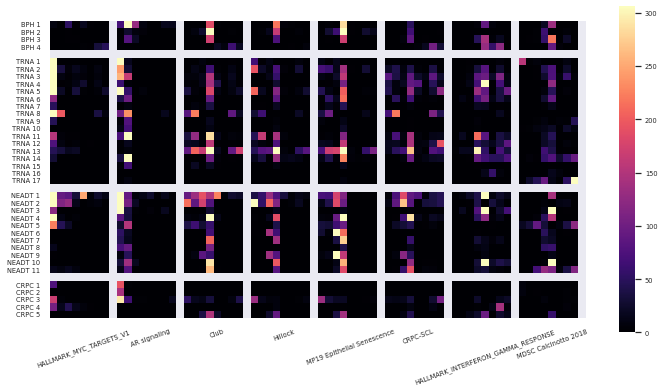

In [24]:
sns.set(font_scale=0.6)

fig,ax = plt.subplots(figsize=(12,6))
sns.heatmap(aggregate_table, cmap='magma', square=True,ax=ax,cbar=True,
    #linewidths=0.5,linecolor='grey'
    )

ax.set_xticklabels(xticks,rotation=20)
ax.set_yticklabels(yticks)

#plt.savefig('plots/gene_signature_scores_summary_heatmap.pdf')
#plt.savefig('plots/gene_signature_scores_summary_heatmap_fewer.pdf')

plt.show()

## Score correlations in samples

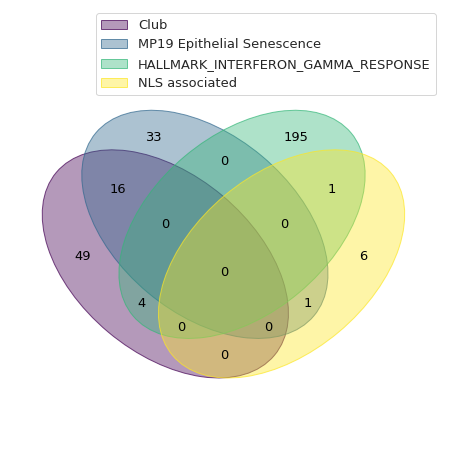

In [11]:
sns.set_theme(style='white')
from venn import venn

set1_name = 'Club'
set2_name = 'MP19 Epithelial Senescence'
set3_name = 'HALLMARK_INTERFERON_GAMMA_RESPONSE'
set4_name = 'NLS associated'
venn_data = {
            set1_name: set(gene_set_df[set1_name].dropna()),
            set2_name: set(gene_set_df[set2_name].dropna()),
            set3_name: set(gene_set_df[set3_name].dropna()),
            set4_name: set(gene_set_df[set4_name].dropna())
            }
fig,ax = plt.subplots(figsize=(8,8))
# Create the Venn diagram
venn(venn_data,ax=ax)
#plt.savefig('plots/gene_signature_venn.pdf')
# Display the diagram
plt.show()

In [25]:
lst = sorted(venn_data['HALLMARK_INTERFERON_GAMMA_RESPONSE'].intersection(venn_data['MP19 Epithelial Senescence']))
for g in lst:
    print(g)

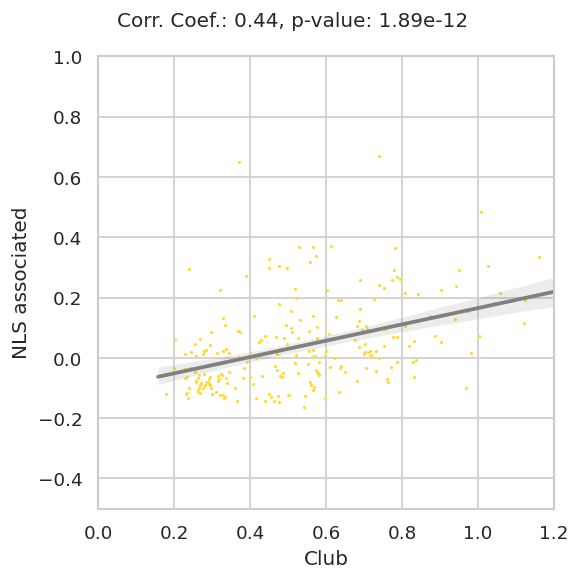

In [48]:
from scipy.stats import pearsonr
sns.set_theme(style='whitegrid')

reg = regions[3]
sample_classes = ['CRPC']#['BPH','TRNA','NEADT','CRPC']
score1 = 'Club'
score2 = 'NLS associated'

# Get the samples you want
valid_samples = []
for sclass in sample_classes:
    for s in masked_ids:
        if sclass in s:
            valid_samples.append(s)

scores_df = all_obs[(all_obs['predicted_region'] == reg) & (all_obs['masked_id'].isin(valid_samples))]

## PLOT ##
fig, ax = plt.subplots(figsize=(5,5),dpi=120)
# create scatterplot with color-coded points
sns.scatterplot(x=score1, y=score2, data=scores_df, color = color_dict[reg], linewidth=0.1, s=2, ax=ax) # 

# add regression line to plot
sns.regplot(x=score1, y=score2, data=scores_df, scatter=False, ax=ax,color='gray')

ax.set_ylim(-0.5,1.0)
ax.set_xlim(0,1.2)

corr_coef, p_value = pearsonr(scores_df[score1], scores_df[score2])
ax.text(x=0.05, y=1.1, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}")

plt.tight_layout()
plt.savefig('plots/score_correlations/'+score1+'_'+score2+'_in_'+'_'.join(sample_classes)+'_'+reg+'.png',dpi=1200)
plt.show()


In [ ]:
gene_set_df

## Macrophage-persist interaction visualization for Ketola

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
untreated_samples = [k for k in treat_info.keys() if treat_info[k] == 'untreated']

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn2
sns.set_theme(style='white')



for sample in untreated_samples:

    obs_data = adata_slides[sample].obs.copy()

    def q_therehold_spots(dat,col,quant=0.99):
        q_thr = dat[col].quantile(quant)
        bcode_set = set(dat[dat[col] > q_thr]['sample_id'].index)
        return bcode_set

    # Define your three sets
    set1 = q_therehold_spots(obs_data,'Persist')
    set2 = q_therehold_spots(obs_data,'M1 macrophages')
    set3 = q_therehold_spots(obs_data,'M2 macrophages')


    ##### Spatial plot ##### 


    slide = adata_slides[sample].copy()

    idx_list1 = list(q_therehold_spots(obs_data, 'Persist') - q_therehold_spots(obs_data, 'M1 macrophages') - q_therehold_spots(obs_data, 'M2 macrophages'))
    idx_list2 = list(q_therehold_spots(obs_data, 'M1 macrophages') - q_therehold_spots(obs_data, 'Persist') - q_therehold_spots(obs_data, 'M2 macrophages'))
    #idx_list2 = M1_confident.index.tolist()

    slide.obs['to_plot'] = 'NA'
    slide.obs['to_plot'] = slide.obs['to_plot'].astype('category')

    slide.obs['to_plot'] = slide.obs['to_plot'].cat.set_categories(['M1 macrophages','Persist','NA'])

    slide.obs.loc[idx_list1,'to_plot'] = 'Persist'
    slide.obs.loc[idx_list2,'to_plot'] = 'M1 macrophages' 

    pal = sns.color_palette(['lightgreen','lightcoral','whitesmoke'])

    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(16,12))


    # Create the Venn diagram
    venn3([set1, set2, set3], ('Persist', 'M1 macrophages', 'M2 macrophages'),ax=ax1,set_colors=['lightcoral','lightgreen','lightblue'])

    sc.pl.spatial(slide,color='to_plot',vmin=min, vmax=max,
                                crop_coord=sample_crop_coord[sample],
                                colorbar_loc=None, size=1.3, alpha_img=0.8, palette=pal,
                                ax=ax2,show=False
                                )

    sq.gr.nhood_enrichment(slide, cluster_key="to_plot",show_progress_bar=False)
    sq.pl.nhood_enrichment(slide, cluster_key="to_plot",annotate=True,ax=ax3)

    ax4.axis('off')
    ax4.text(0.3, 0.5, "Persist score q0.95: {:.2f}\nM1 macrophages score q0.95: {:.2f}\nM2 macrophages score q0.95: {:.2f}".format(
        obs_data['Persist'].quantile(0.95),
        obs_data['M1 macrophages'].quantile(0.95),
        obs_data['M2 macrophages'].quantile(0.95)),
        ha='left', va='center',fontsize=16)

    plt.tight_layout()
    plt.savefig('./plots/macrophage_persist_proximity_in_untreated/'+sample+'_multi_panel.pdf')
    plt.clf()

## Plot sample grids 

### Plot proportional inferred cell counts

In [ ]:
# Normalize by the number of cells inferred to be present at each location

cell_types = adata_slides[samples[0]].obs.columns[16:].tolist()

cell_proportions = {}

for sample in samples:
    df = adata_slides[sample].obs[cell_types]
    inferred_cell_numbers = df.sum(axis=1).tolist()
    
    df = df.div(df.sum(axis=1), axis=0)
    df['n_cells'] = inferred_cell_numbers
    cell_proportions[sample] = df.copy()


for sample in samples:
    slide = adata_slides[sample]
    df = cell_proportions[sample]
    for ctype in cell_types:
        slide.obs[ctype] = df[ctype].copy()

    slide.obs['n_cells'] = df['n_cells'].copy()

In [ ]:
# Plot the inferred cell prevalences as a test
# You can plot whichever metric here
for var_to_plot in cell_types:

    it=0

    concat_obs = pd.DataFrame(columns=adata_slides[samples[it]].obs.columns)
    for slide in adata_slides:
        concat_obs = pd.concat([concat_obs,adata_slides[slide].obs.copy()],axis=0)

    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)
    
    min = 0#concat_obs[var_to_plot].quantile(0.05)
    max = 1#concat_obs[var_to_plot].quantile(0.95)


    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                sc.pl.spatial(adata_slides[samples[it]],color=var_to_plot,title=samples[it],
                            vmin=min, vmax=max,crop_coord=sample_crop_coord[samples[it]],
                            colorbar_loc=None, cmap='viridis', size=1.3, alpha_img=0.8, legend_loc=None,
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create a custom axes for the colorbar
    cax = fig.add_axes([0.66, 0.1, 0.3, 0.04])
    # draw the colorbar on the custom axes with horizontal orientation
    fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=min, vmax=max), cmap='viridis'), cax=cax, orientation='horizontal')
    cax.set_title(var_to_plot)


    plt.savefig('./plots/all_samples_grid/'+var_to_plot+'_on_all_spatial_sections.pdf')
    plt.clf()


### Plot predicted regions on all samples

In [ ]:
import matplotlib.patches as patches

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())

In [ ]:

it=0
fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

for i in range(5):
    for j in range(8):
        
        if it < len(samples):
            sc.pl.spatial(adata_slides[samples[it]],color='predicted_region',title=sample_id_mask_dict[samples[it]],
                        crop_coord=sample_crop_coord[samples[it]],
                        size=1.3, alpha_img=0.8, legend_loc=None,
                        ax=axs[i,j],show=False
                        )

            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()

# create custom axes for the annotation legend 
cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

cax1.axis('off')
cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='xx-large')
cax2.axis('off')
cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='xx-large')


plt.savefig('./plots/regions_on_all_samples_spatial.pdf')
plt.clf()
#plt.show()


### Plot predicted regions one at a time

In [ ]:

for region_of_interest in regions:
    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                slide = adata_slides[samples[it]].copy()
                slide.obs['region_of_interest'] = np.nan
                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

                try:
                    n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]
                except:
                    n_spots=0

                sc.pl.spatial(slide,color='region_of_interest',title=samples[it]+ ' ({:d})'.format(n_spots),
                            crop_coord=sample_crop_coord[samples[it]],
                            size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


    plt.savefig('./plots/all_samples_grid/'+region_of_interest+'_region_on_all_spatial_sections.pdf')
    plt.clf()
    #plt.show()


### Plot predicted regions one sample at a time

In [ ]:
for sample in samples:
    
    it=0

    fig, axs = plt.subplots(2, 4, figsize=(12, 6),dpi=120)

    slide = adata_slides[sample].copy()

    for i in range(2):
        for j in range(4):
        
            region_of_interest = regions[it]

            if region_of_interest in slide.obs['predicted_region'].unique():
                
                slide.obs['region_of_interest'] = np.nan

                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

            
                n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

                sc.pl.spatial(slide,color='region_of_interest',title=region_of_interest+ ' ({:d})'.format(n_spots),
                        crop_coord=sample_crop_coord[sample],
                        size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                        ax=axs[i,j],show=False
                        )
                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)

            else:
                axs[i,j].set_visible(False)
            
            it+=1
    
    plt.tight_layout()
    plt.savefig('./plots/all_samples_grid/region_based/sample_specific/'+sample+'_all_regions_individually.pdf')
    plt.clf()
    #plt.show()


## Stacked barplot of region proportions on samples + sample mask order (Figure 3a)

In [ ]:
df = all_obs[['sample_id','predicted_region']]

# Calculate the proportion of data points in each predicted_region class
counts = df['predicted_region'].value_counts(normalize=True)

# Pivot the dataframe to create a matrix of values
df_pivot = df.pivot_table(index='sample_id', columns='predicted_region', aggfunc='size', fill_value=0)

# Normalize the values in each row
df_norm = df_pivot.div(df_pivot.sum(axis=1), axis=0)

treat_info = get_treatment_info()
for k in list(treat_info.keys()):
    if (treat_info[k] == 'bicalutamide') | (treat_info[k] ==  'goserelin'):
        treat_info[k] = 'neoadjuvant'


df_norm['treatment'] = df_norm.index.map(treat_info)

# Get the sample ids into a order where they are grouped by sample categories, but also decrease in tumor 
# content within categories
stacked_bar_sample_order = []
for trt in df_norm['treatment'].unique():
    stacked_bar_sample_order += df_norm[df_norm['treatment'] == trt].sort_values(['Tumor'],ascending=False).index.tolist()

In [ ]:
# assuming your dataframe is named df
pivot_table = df.groupby('sample_id')['predicted_region'].value_counts(normalize=True).unstack()

# Set the pre-defined order
pivot_table = pivot_table.loc[stacked_bar_sample_order]

# plot the stacked barplot
fig, ax = plt.subplots(figsize=(12,3),dpi=300)
pivot_table.plot.bar(stacked=True, color=region_colors,legend=False,width=0.8,edgecolor='black',ax=ax)

# add labels and title
plt.xlabel('Sample ID Class')
plt.ylabel('Count')
plt.gca().set_yticks([0.2,0.4,0.6,0.8,1.0])

#plt.tight_layout()
plt.savefig('plots/region_proportions_all_samples.pdf')
plt.clf()


In [ ]:
# Save the masking dict in this order

pseoudo_ids = ['BPH ' + str(i) for i in np.arange(1,5)] + ['TRNA ' + str(i) for i in np.arange(1,18)] + ['NEADT ' + str(i) for i in np.arange(1,12)] + ['CRPC ' + str(i) for i in np.arange(1,6)]
masking_dict = dict(zip(stacked_bar_sample_order,pseoudo_ids))
masking_df = pd.DataFrame(masking_dict,index=np.arange(1)).T.reset_index()
masking_df.columns = ['PAD','Pseudo_ID']
masking_df.to_csv('patient_id_mask.csv',sep=';',index=False)

## Single sample expression categorized by region (heatmap 2x)

In [ ]:
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')


In [ ]:
from scipy.stats import zscore

# Specific slide or all data?
sample = 'PC_06_04581_OIK_POST_0'
slide = adata_slides[sample].copy()
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
#slide = ad.concat(adata_slides)


sc.tl.rank_genes_groups(slide,groupby='predicted_region',method='wilcoxon')

spots_list = []
region_spans = {}
prev_region = ''

for region in regions:
    lst = slide.obs[slide.obs['predicted_region'] == region].index.tolist()
    spots_list += lst
    if prev_region != '':
        region_spans[region] = region_spans[prev_region] + len(lst)
    else:
        region_spans[region] = len(lst)
    prev_region = region

region_pos = list(region_spans.values())


In [ ]:
n_genes = 50
gene_list = []
row_lines = []

for i in range(n_genes, n_genes*len(regions)+1, n_genes):
    row_lines.append(i)

for region in regions:
    deg_res = sc.get.rank_genes_groups_df(slide,group=region)

    deg_res = deg_res[~deg_res['names'].isin(gene_list)] # Take out genes that are already used as markers
    deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
    deg_res = deg_res[~deg_res['names'].str.startswith('MT')]

    deg_res_sorted = deg_res.sort_values(['scores'],ascending=False).reset_index(drop=True)
    gene_list += deg_res_sorted[:n_genes]['names'].tolist()
genes_as_series = pd.Series(gene_list)
#genes_as_series = genes_as_series[~genes_as_series.duplicated()]


dat = slide[:,genes_as_series.tolist()].X.copy().T
#dat = slide[:,genes_as_series.tolist()].layers['counts'].todense().T
df_to_plot = pd.DataFrame(data=dat,columns=slide.obs_names,index=genes_as_series.tolist())[spots_list]


df_to_plot = df_to_plot.apply(zscore,axis=1)

In [ ]:
sns.set_theme(style='whitegrid')
fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(df_to_plot,cmap='viridis',xticklabels=False,yticklabels=False,vmin=-1, vmax=2)
ax.vlines(region_pos,colors='white', lw=0.5, ymin=-1, ymax=df_to_plot.shape[0])
ax.hlines(row_lines,colors='white', lw=0.5, xmin=-1, xmax=df_to_plot.shape[1])

plt.savefig('./plots/'+sample+'_region_expression_heatmap.png',dpi=800)
plt.show()

In [ ]:
# Barplot of the numer of spots belonging to each region
concat_obs = pd.DataFrame()
for sample in samples:
    concat_obs = pd.concat([concat_obs,adata_slides[sample].obs.copy()],axis=0)

plt.figure(figsize=(3,3))
barplot_df = concat_obs.predicted_region.value_counts().loc[regions]
barplot_df.plot.bar(color=region_colors,width=1)
plt.axhline(y=10000,linestyle='--',color='black',linewidth=1)
plt.axhline(y=20000,linestyle='--',color='black',linewidth=1)
plt.xticks(rotation=60)
plt.savefig('./plots/region_prevalence_barplot.pdf')

## Visualize marker gene expression in relation to regions

### Looking at region proportions (% of spots belonging to a region) across treatment classes (swarmplot 4a)

In [ ]:
from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
concat_obs = concat_adata.obs.copy()
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)


def get_spot_proportions(region,sample_list=samples,slides=adata_slides,treatment_info=treat_info):
    df = pd.DataFrame(index=samples,columns=[region + ' spots','total spots','treatment'])
    for sample in sample_list:
        df.loc[sample,'total spots'] = len(adata_slides[sample])
        df.loc[sample,region + ' spots'] = len(slides[sample][slides[sample].obs['predicted_region'] == region])
    df['proportion'] = df[region+' spots'] / df['total spots']
    df['treatment'] = df.index.map(treatment_info)

    # Re-annotate
    df['treatment'] = df['treatment'].replace({'bicalutamide':'treated','goserelin':'treated'})

    df['treatment'] = df['treatment'].astype('category')    
    df['proportion'] = df['proportion'].astype(float)

    return(df)


In [ ]:
sns.set_theme(style='whitegrid')

order = ['bph', 'untreated', 'treated','crpc']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))

for i, region in enumerate(regions):
    row = i // 4
    col = i % 4
    ax = axes[row][col]

    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=4, color=".7",ax=ax)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=ax)
    ax.set_ylim(0,1)
    ax.set_title(region)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

plt.tight_layout()
plt.savefig('./plots/region_proportions_swarmplot.pdf')
plt.show()

In [ ]:
sns.set_theme(style='whitegrid')

order = ['bph', 'untreated', 'treated','crpc']

for i, region in enumerate(regions):
    sns.set_palette(sns.color_palette([color_dict[region]]))    
    fig, ax = plt.subplots(figsize=(4,5))
    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=6, ax=ax) # color=".7",)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            width=0.3,
            ax=ax)
    ax.set_ylim(-0.1,1.1)
    ax.set_title(region)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)

    plt.tight_layout()
    plt.savefig('./plots/region_proportion_swarmplots/'+region+'_proportions_swarmplot.pdf')
    plt.show()

In [ ]:
# Perform statistical testing of possible differences in spot proportions between samples
# Use these to draw significance bars on top of the swarmplots

from scipy.stats import kruskal
import scikit_posthocs as sp

for region in regions:
    df = get_spot_proportions(region)
    df['treatment'] = df['treatment'].cat.reorder_categories(['bph','untreated','treated','crpc'])

    # extract the values and categories from the dataframe
    values = df['proportion']
    categories = df['treatment']

    # perform the Kruskal-Wallis test
    statistic, p_value = kruskal(*[values[categories == cat] for cat in set(categories)])

    print(region)
    # print the results
    print("Kruskal-Wallis test")
    print("p-value: {:.3f}".format(p_value))

    if p_value < 0.05:
        print(sp.posthoc_conover(df, val_col='proportion', group_col='treatment'))
    print('')

### Looking at the marker genes of a specific region independently one sample at a time (dotplot 2b)

In [ ]:
# Calculate DEGs between regions individually in samples
# This takes several minutes with method='wilcoxon',
# About a minute with method='t-test'
for sample in samples:

    slide = adata_slides[sample]#.copy()

    # Remove a group if it has less than 10 spots in it
    val_counts = slide.obs['predicted_region'].value_counts()
    category_groups = val_counts[~(val_counts < 10)].index.tolist()

    sc.tl.rank_genes_groups(slide,groupby='predicted_region', method='wilcoxon',groups=category_groups,random_state=25813063)


In [ ]:
from scripts.utils import get_sample_id_mask
masked_sample_ids = get_sample_id_mask()

# Take a region one at a time, extract DEG results, save into a list

region_degs_dict = {}
for region in regions:
    deg_res_all = pd.DataFrame()

    for sample in samples:

        slide = adata_slides[sample]

        try:
            deg_res = sc.get.rank_genes_groups_df(slide,group=region)

            deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
            deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
            deg_res['sample'] = sample #masked_sample_ids[sample]
            deg_res = deg_res[(deg_res['pvals_adj']<0.05) & (deg_res['logfoldchanges']>=1)].reset_index(drop=True)


            deg_res_all = pd.concat([deg_res_all,deg_res],axis=0)
        except:
            continue

    region_degs_dict[region] = deg_res_all

region_degs_dict

In [ ]:
date = datetime.now().strftime('%y%m%d')

save_to_pickle(region_degs_dict,'./data/region_gene_markers_signif_degs_'+date+'.pkl')

In [ ]:
region_sample_counts = {}
df_gene_counts = pd.DataFrame()
for r in regions:
    df_gene_counts = pd.merge(region_degs_dict[r]['names'].value_counts().rename(r),df_gene_counts,left_index=True,right_index=True,how='outer')
    region_sample_counts[r] = len(region_degs_dict[r]['sample'].unique())
df_gene_counts = df_gene_counts.fillna(0).astype(int)


In [ ]:
# Take DEG results and perform enrichment analysis:
# Check in how many samples this gene is overexpressed in a specific region
# Compare this to how many samples the same gene is overexpressed in 
# If there is a significant enrichment for this marker in a region, it can be considired region specific


from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

signif_pval_interactions = {}

for reg in regions:
    
    df = df_gene_counts.copy()
    other_keys = [c for c in df.columns if c != reg]

    n_sample = region_sample_counts[reg]
    n_control = pd.Series([region_sample_counts[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[reg].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]


    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                'active_in':df[reg].astype(int).tolist(),
                                'adj_pval':df['adj_pval'].tolist(),
                                'interface':np.repeat(reg,len(df))})

    signif_pval_interactions[reg] = df_signif.copy()


date = datetime.now().strftime('%y%m%d')
save_to_pickle(signif_pval_interactions,'./data/region_gene_markers_fishers_exact_test_'+date+'.pkl')

In [ ]:
# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_3.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in region_degs_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value['sample'] = value['sample'].map(sample_id_masks)
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()


In [ ]:
marker_genes_for_hmap = ['PRAC1','HPN','PCAT14','AMACR','PCA3', # Tumor
                         'MSMB','ACPP','RDH11','NKX3-1','AZGP1', # Luminal
                         'KRT5','KRT15','TRIM29','TP63','SLC14A1', # Basal 
                         'MMP7','PIGR','LTF','CP','KRT7', # Intermediate
                         'CXCR4','TRBC1','CD3D','LYZ','CD79A', # Lymphocyte
                         'EPAS1','EMP1','VWF','PECAM1','IFI27', # Endothelium
                         'DCN','LUM','FBLN1','SFRP2','COL1A1', # Fibroblast
                         'TAGLN','ACTA2','ACTG2','MYH11','MYL9' # Muscle
                         ]

In [ ]:
plot_df = pd.DataFrame()
for region in regions:
    degs = region_degs_dict[region]
    n_samples = len(degs['sample'].unique())
    
    degs = degs[degs['names'].isin(marker_genes_for_hmap)]
    
    mean_lfc_list = []
    proportion_degs_list = []

    for gene in marker_genes_for_hmap:

        if gene in degs['names'].values:
            mean_lfc = degs[degs['names'] == gene]['logfoldchanges'].mean()
            proportion_degs = degs['names'].value_counts()[gene] / n_samples
            mean_lfc_list.append(mean_lfc)
            proportion_degs_list.append(proportion_degs)
        
        else:
            mean_lfc_list.append(np.nan)
            proportion_degs_list.append(0)
    
    df = pd.DataFrame({'mean_logfoldchange': mean_lfc_list,'pct_deg_in': proportion_degs_list, 'region': region},index = marker_genes_for_hmap)
    plot_df = pd.concat([plot_df,df],axis=0)

plot_df['genes'] = plot_df.index.astype(str)

plot_df.loc[plot_df['pct_deg_in']==0,'pct_deg_in'] = np.nan

In [ ]:

# Create the dotplot
sns.set(style='white')

width = 18
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions,yticks_list)))
sns.scatterplot(x='genes', y='region_y', size='pct_deg_in', hue='mean_logfoldchange', 
                data=plot_df, sizes=(40, 400), palette='Reds', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.savefig('./plots/region_gene_markers_dotplot.pdf')
plt.show()


In [ ]:
# Plot as a heatmap

plot_df = pd.DataFrame(index=regions,columns=marker_genes_for_hmap,dtype=int)

for gene in marker_genes_for_hmap:
    for region in regions:
 
        region_degs = region_degs_dict[region].copy()

        region_deg_val_counts = region_degs['names'].value_counts()

        if gene not in region_deg_val_counts.index:
            plot_df.loc[region,gene] = 0
        else:
            plot_df.loc[region,gene] = region_deg_val_counts.loc[gene]
            
fig,ax = plt.subplots(figsize=(15,5))
sns.heatmap(plot_df,square=True,cmap='Reds',annot=False,vmax=len(samples),ax=ax)
plt.savefig('./plots/all_samples_tissue_region_marker_genes.pdf')


In [ ]:
plot_df.to_excel('./source_data/figure_2d.xlsx',engine='xlsxwriter')

### Plot expresison violins for multiple markers in multiple regions (alternative violinplot 2d)

In [ ]:
# Get the top n genes for each region and save them into a list

gene_list = []
n_genes = 10

for region in regions:
    deg_res = sc.get.rank_genes_groups_df(concat_adata,group=region)

    #deg_res = deg_res[~deg_res['names'].isin(gene_list)] # Take out genes that are already used as markers
    deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
    deg_res = deg_res[~deg_res['names'].str.startswith('MT')]

    deg_res_sorted = deg_res.sort_values(['scores'],ascending=False).reset_index(drop=True)
    #deg_res_sorted = deg_res.sort_values(['logfoldchanges'],ascending=False)[deg_res['pvals_adj']<0.05].reset_index(drop=True)
    gene_list += deg_res_sorted[:n_genes]['names'].tolist()

origin = [item for sublist in [np.repeat(region,n_genes).tolist() for region in regions] for item in sublist]
genes_df = pd.DataFrame(gene_list,origin,columns=['gene'])


In [ ]:
sns.set_theme(style='whitegrid')
for region in regions:
    gene_list = genes_df.loc[region]['gene']
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(24, 6))

    for i, gene in enumerate(gene_list):
        row = i // 5
        col = i % 5
        ax = axs[row, col]
        sc.pl.violin(concat_adata, keys=gene, groupby='predicted_region', order=regions, rotation=20, jitter=False, inner='box', ax=ax,show=False, use_raw=True)#,layer='counts')
        ax.set_ylim(0, 6)
        
    plt.tight_layout()
    #plt.show()
    plt.savefig('./plots/gene_violins/'+region + '_top_genes_violin_plots.png',dpi=120)
    plt.clf()


In [ ]:
concat_adata = ad.concat(adata_slides,join='outer')

In [ ]:
concat_adata.uns['predicted_region_colors'] = region_colors
concat_adata.obs['predicted_region'] = concat_adata.obs['predicted_region'].cat.set_categories(regions)

# This list of genes is from 
custom_gene_list = ['RACK1','PRAC1','EEF2', # Tumor
                    'MSMB','KLK2','ACPP', # Luminal
                    'KRT5','KRT15','TP63', # Basal
                    'LTF','ANXA2','KRT19', # Intermed
                    'CD74','HLA-DRA','TRBC2', # Lymphocyte
                    'VWF','IFI27','A2M', # Endothelium
                    'DCN','LUM','FBLN1', # Fibroblast
                    'MYL9','ACTA2','TPM2'] # Muscle

In [ ]:
sns.set_theme(style='whitegrid')

fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(24, 6))

for i, gene in enumerate(custom_gene_list):
    col = i // 3
    row = i % 3
    ax = axs[row, col]
    sc.pl.violin(concat_adata, keys=gene, groupby='predicted_region', order=regions, jitter=False, inner='box', ax=ax,show=False, use_raw=True)#,layer='counts')
    ax.set_ylim(0, 6)
    
plt.tight_layout()
#plt.savefig('./plots/gene_violins/custom_genes_of_interest_top_genes_violin_plots.pdf')
plt.savefig('./plots/gene_violins/custom_genes_of_interest_top_genes_violin_plots.png',dpi=600)
plt.clf()


## Visualize score enrichments in regions (violin plots)

In [ ]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')

In [ ]:
# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

df = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    df = pd.concat([df,adata_slides[sample].obs.copy()],axis=0)

# You could take whichever sample, just get the region order    
regions = adata_slides[samples[10]].obs['predicted_region'].cat.categories.tolist() 
df['predicted_region'] = df['predicted_region'].astype('category').cat.set_categories(regions)

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]


### Plot specific scores in specific samples

In [ ]:
treatment_naive_samples = get_sample_ids_reorder(['BPH','untreated'])
only_treat_naive = True

from scipy.stats import ttest_1samp
sns.set_theme(style='whitegrid')
sns.set_palette(region_colors)


In [ ]:
for col in gene_set_df.columns:

#for col in ['MP19 Epithelial Senescence', 'MP23 Secreted II', 'Persist', 'CRPC-SCL']:
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120)


    if only_treat_naive:
        # Take only the treatmeent naives samples
        df_to_plot = df[df['sample_id'].isin(treatment_naive_samples)][['sample_id',col,'predicted_region']]

    else:
        # No sample filtering
        df_to_plot = df[['sample_id',col,'predicted_region']]

    # RENAMING CATEGORIES
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].replace(replace_dict)

    score_mean = df_to_plot[col].mean()

    # Since the scores are run on z-normalized data, the overall mean is 0
    ax.axhline(score_mean, linestyle='--', color='black') 

    sns.violinplot(data=df_to_plot, x='predicted_region', y=col,ax=ax)

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.25
    ax.set(ylim=(ymin, ymax))
    plt.legend().remove()

    for idx,reg in enumerate(regions):

        reg_scores = df_to_plot[df_to_plot['predicted_region']==reg][col]

        if ttest_1samp(reg_scores,0,axis=None,alternative='greater')[1] <0.01:

            t_stat, p_val = ttest_1samp(reg_scores,score_mean,axis=None,alternative='greater')

            ## Make p-value and magnitude requirements
            if p_val<0.01 and ((score_mean < reg_scores.quantile(0.05))):
                asterisks = '***'
            elif p_val<0.01 and ((score_mean < reg_scores.quantile(0.15))):
                asterisks = '**'
            elif p_val<0.01 and ((score_mean < reg_scores.quantile(0.25))):
                asterisks = '*'
            else:
                asterisks = ''
                
            ax.text(idx, ymax+0.05, asterisks, fontsize=20,ha='center', va='center')
            
            #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    #ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
    ax.set_xticklabels([], rotation=15)
        
    plt.tight_layout()
    
    if only_treat_naive:
        plt.savefig('./plots/score_violins/untreated/scanpy_'+col.replace('/','_')+'_score_untreated.pdf')
    else: 
        plt.savefig('./plots/score_violins/untreated/scanpy_'+col.replace('/','_')+'_score_all.pdf')
    plt.clf()
    #plt.show()

## Visualize gene set activity scores in relation to treatment

### Data download

In [3]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
scanpy_res = load_from_pickle('./data/spatial_scanpy_score_results.pkl')

In [4]:
# Concatenate the scoring results into a single anndata
for sample in samples:
    slide = adata_slides[sample]
    slide.obs  = pd.concat([slide.obs,scanpy_res[sample]],axis=1)

df = pd.DataFrame() # Create empty dataframe for obs
for sample in samples:
    df = pd.concat([df,adata_slides[sample].obs.copy()],axis=0)

# You could take whichever sample, just get the region order    
regions = adata_slides[samples[10]].obs['predicted_region'].cat.categories.tolist() 
df['predicted_region'] = df['predicted_region'].astype('category').cat.set_categories(regions)

In [5]:
# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)


from scripts.utils import get_treatment_info
treat_info = get_treatment_info()
df['treatment'] = df['sample_id'].map(treat_info)
df['predicted_region'] = df['predicted_region'].replace(replace_dict)

region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))

### Plot the aggragated regions according to treatment class

In [ ]:
from scipy.stats import ttest_ind
sns.set_theme(style='whitegrid')

pal = sns.color_palette(['lightcoral','lightgreen'])
sns.set_palette(pal)

for col in gene_set_df.columns:

    # Don't filter anys sample out
    #pca_samples = samples.copy()
    pca_samples = get_sample_ids_reorder(['BPH','untreated','bicalutamide','goserelin'])

    fig, ax = plt.subplots(1, 1, figsize=(6, 3), dpi=120)

    df_to_plot = df[['sample_id',col,'treatment','predicted_region']][df['sample_id'].isin(pca_samples)]

    df_to_plot['sample_id'] = df_to_plot['sample_id'].astype('category').cat.set_categories(pca_samples)

    df_to_plot['treatment'] = df_to_plot['treatment'].replace(['bph'], 'untreated')
    df_to_plot['treatment'] = df_to_plot['treatment'].replace(['bicalutamide', 'goserelin'], 'treated') # 'crpc'

    # RENAMING CATEGORIES
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].replace(replace_dict)

    ymin = df_to_plot[col].min() -0.1
    ymax = df_to_plot[col].max() +0.25

    # Plot quantile lines to keep track of how the score behaves
    #ax.axhline(df_to_plot[df_to_plot['treatment']=='untreated'][col].mean(), linestyle='--', color=sns.color_palette()[0]) 
    #ax.axhline(df_to_plot[df_to_plot['treatment']=='treated'][col].mean(), linestyle='--', color=sns.color_palette()[1]) 

    ax = sns.violinplot(data=df_to_plot, x='predicted_region', y=col, hue='treatment',ax=ax,split=True, inner = None)
    ax.set(ylim=(ymin, ymax))

    for idx,reg in enumerate(regions):

        groups = [group[col] for name, group in df_to_plot[df_to_plot['predicted_region']==reg].groupby('treatment')]
        f_stat, p_val = ttest_ind(*groups)

        ## Make p-value and magnitude requirements
        if p_val<0.01 and ((groups[0].mean() > groups[1].quantile(0.95)) or (groups[0].mean() < groups[1].quantile(0.05))):
            asterisks = '***'
        elif p_val<0.01 and ((groups[0].mean() > groups[1].quantile(0.85)) or (groups[0].mean() < groups[1].quantile(0.15))):
            asterisks = '**'
        elif p_val<0.01 and ((groups[0].mean() > groups[1].quantile(0.75)) or (groups[0].mean() < groups[1].quantile(0.25))):
            asterisks = '*'
        else:
            asterisks = ''
            
        ax.text(idx, ymax +0.05, asterisks, fontsize=20,ha='center', va='center')
        
        #print(reg + ' t-test p-value: {:.2e}'.format(p_val))

    ax.set_xticklabels([], rotation=15)
    #ax.legend(loc='lower right')
    ax.legend_.remove()
        
    plt.tight_layout()
    plt.savefig('./plots/score_violins/treatment_comparison/'+col.replace('/','_')+'_scanpy_scores_by_regions_PCa_treatment.pdf')
    plt.clf()
    #plt.show()

### Plot Club region vs other epithelial as a side-by-side violin


In [6]:
from scipy.stats import ttest_ind

sns.set_theme(style='whitegrid')
only_epithelial_regions = True
epithelial_regions = regions[:4]

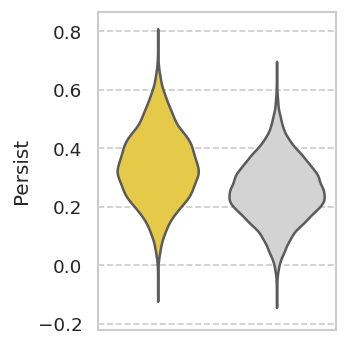

In [8]:
modules_of_interest = ['Persist']
#modules_of_interest = gene_set_df.columns
region_of_interest = 'Intermediate epithelium'


region_selection_dict = dict(zip(regions,[region if region == region_of_interest else 'Other' for region in regions]))


for col in modules_of_interest:

    fig, ax = plt.subplots(figsize=(3, 3), dpi=120)

    # No sample filtering
    df_to_plot = df[['sample_id',col,'predicted_region']]

    # RENAMING CATEGORIES
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].replace(replace_dict)


    if only_epithelial_regions:
        df_to_plot = df_to_plot[df_to_plot['predicted_region'].isin(epithelial_regions)]

    df_to_plot['regions_to_plot'] = df_to_plot['predicted_region'].map(region_selection_dict).astype('category')

    df_to_plot['regions_to_plot'] = df_to_plot['regions_to_plot'].cat.set_categories([region_of_interest,'Other'])

    sns.set_palette(sns.color_palette([color_dict[region_of_interest],'lightgrey']))

    sns.violinplot(data=df_to_plot, x='regions_to_plot', y=col,ax=ax,inner=None)
    #ax.get_legend().remove()

    # Plot y-axis lines between known interwals
    plt.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.1

    ax.set(ylim=(ymin, ymax))
    
    # Do the t-tests
    sample = df_to_plot[df_to_plot['regions_to_plot']==region_of_interest][col]
    control = df_to_plot[~(df_to_plot['regions_to_plot']==region_of_interest)][col]

    stat,p_val = ttest_ind(sample,control)

    ## Make p-value and magnitude requirements
    if p_val<0.01 and ((control.mean() < sample.quantile(0.05)) or (control.mean() > sample.quantile(0.95))):
        asterisks = '***'
    elif p_val<0.01 and ((control.mean() < sample.quantile(0.15)) or (control.mean() > sample.quantile(0.85))):
        asterisks = '**'
    elif p_val<0.01 and ((control.mean() < sample.quantile(0.25)) or (control.mean() > sample.quantile(0.75))):
        asterisks = '*'
    else:
        asterisks = ''
        
    ax.text(0.5, ymax+0.05, asterisks, fontsize=20,ha='center', va='center')
        

    ax.set_xticklabels([])
    #ax.set_yticklabels([])

    ax.set_xlabel('')
    plt.tight_layout()
    
    #if asterisks != '':
    plt.savefig('./plots/score_violins/club_vs_other_epithelial/scanpy_'+col.replace('/','_')+'_score.pdf')
    plt.show()
    #else:
    #    plt.clf()

### Plot Club region vs other epithelial as split violin according to treatment


In [ ]:
from scipy.stats import ttest_ind

sns.set_theme(style='whitegrid')
only_epithelial_regions = True
epithelial_regions = regions[:4]

In [ ]:
pal = sns.color_palette(['lightcoral','lightgreen'])
sns.set_palette(pal)

#modules_of_interest = ['HALLMARK_COMPLEMENT','HALLMARK_INTERFERON_GAMMA_RESPONSE','MP19 Epithelial Senescence', 'MP23 Secreted II', 'Persist', 'CRPC-SCL']
modules_of_interest = gene_set_df.columns
region_of_interest = 'Intermediate epithelium'


region_selection_dict = dict(zip(regions,[region if region == region_of_interest else 'Other' for region in regions]))
regs = regions


for col in modules_of_interest:

    fig, ax = plt.subplots(figsize=(6, 3), dpi=120)

    pca_samples = get_sample_ids_reorder(['BPH','untreated','bicalutamide','goserelin'])
    # Yes sample filtering
    df_to_plot = df[['sample_id',col,'predicted_region','treatment']][df['sample_id'].isin(pca_samples)]

    # RENAMING CATEGORIES
    df_to_plot['predicted_region'] = df_to_plot['predicted_region'].replace(replace_dict)

    df_to_plot['treatment'] = df_to_plot['treatment'].replace(['bph'], 'untreated')
    df_to_plot['treatment'] = df_to_plot['treatment'].replace(['bicalutamide', 'goserelin'], 'treated') # 'crpc'

    if only_epithelial_regions:
        df_to_plot = df_to_plot[df_to_plot['predicted_region'].isin(epithelial_regions)]
        regs = epithelial_regions

        df_to_plot['regions_to_plot'] = df_to_plot['predicted_region'].copy().cat.set_categories(epithelial_regions)

        # Here you can affect whether regions are concatenated as 'other
        df_to_plot['regions_to_plot'] = df_to_plot['predicted_region'].map(region_selection_dict).astype('category')
        df_to_plot['regions_to_plot'] = df_to_plot['regions_to_plot'].cat.set_categories([region_of_interest,'Other'])
        regs = df_to_plot['regions_to_plot'].cat.categories

    ax = sns.violinplot(data=df_to_plot, x='regions_to_plot', y=col, hue='treatment',ax=ax,split=True, inner = None)
    

    # Plot y-axis lines between known interwals
    plt.grid(True, which='both', linestyle='--', axis='y', linewidth=1)
    plt.yticks(np.arange(-1,2,0.2).astype(float))

    ymin = df_to_plot[col].min()-0.1
    ymax = df_to_plot[col].max()+0.1

    ax.set(ylim=(ymin, ymax))
    
    # Do the t-tests
    sample = df_to_plot[df_to_plot['regions_to_plot']==region_of_interest][col]
    control = df_to_plot[~(df_to_plot['regions_to_plot']==region_of_interest)][col]

    stat,p_val = ttest_ind(sample,control)

    asterisks_list = []
    for idx,reg in enumerate(regs):

        groups = [group[col] for name, group in df_to_plot[df_to_plot['regions_to_plot']==reg].groupby('treatment')]
        f_stat, p_val = ttest_ind(*groups)

        ## Make p-value and magnitude requirements
        if p_val<0.01 and ((groups[0].mean() > groups[1].quantile(0.95)) or (groups[0].mean() < groups[1].quantile(0.05))):
            asterisks = '***'
        elif p_val<0.01 and ((groups[0].mean() > groups[1].quantile(0.85)) or (groups[0].mean() < groups[1].quantile(0.15))):
            asterisks = '**'
        elif p_val<0.01 and ((groups[0].mean() > groups[1].quantile(0.75)) or (groups[0].mean() < groups[1].quantile(0.25))):
            asterisks = '*'
        else:
            asterisks = ''
        
        if asterisks != '':
            asterisks_list.append(asterisks)
            ax.text(idx, ymax +0.05, asterisks, fontsize=20,ha='center', va='center')
        
        
    ax.legend_.remove()

    ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
    ax.set_xlabel('')
    plt.tight_layout()
    
    if len(asterisks_list) != 0:
        plt.savefig('./plots/score_violins/club_vs_other_epithelial_treatment/scanpy_'+col.replace('/','_')+'_score_2_categories.pdf')
        plt.show()
    else:
        plt.clf()

### Draw score correlation plots

In [ ]:
unt = ['bph','untreated']
treated = ['bicalutamide','goserelin']
scores = ['AR signaling','Persist','CRPC-SCL','MP22 Secreted I','MP17 Interferon/MHC-II (I)','MP18 Interferon/MHC-II (II)','MP23 Secreted II','MP19 Epithelial Senescence']

In [ ]:
from scipy.stats import pearsonr
from itertools import combinations
from matplotlib import pyplot as plt

score_combs = list(combinations(scores,2))

sns.set_theme(style='whitegrid')
sns.set_palette(sns.color_palette(region_colors))



for score_tuple in score_combs:
    score1 = score_tuple[0]
    score2 = score_tuple[1]

    untreated_scores = df[df['treatment'].isin(unt)]#.sample(frac=0.1)
    treated_scores = df[df['treatment'].isin(treated)]#.sample(frac=0.1)

    xmin = df[score1].min()
    xmax = df[score1].max()-0.2
    ymin = df[score2].min()
    ymax = df[score2].max()-0.2

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5),dpi=120)
    # create scatterplot with color-coded points
    sns.scatterplot(x=score1, y=score2, data=untreated_scores, hue='predicted_region', s=1, ax=axs[0])

    # add regression line to plot
    sns.regplot(x=score1, y=score2, data=untreated_scores, scatter=False, ax=axs[0],color='gray')

    # Add cluster centres on the plot
    sns.scatterplot(x=score1,y=score2,
    data=untreated_scores[[score1,score2,'predicted_region']].groupby('predicted_region').mean().reset_index(),
    hue='predicted_region',s=300,marker='x',ax=axs[0])

    # add correlation coefficient and p-value to plot
    corr_coef, p_value = pearsonr(untreated_scores[score1], untreated_scores[score2])
    axs[0].text(x=0.05, y=0.95, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}", transform=axs[0].transAxes)

    ############################
    # In treated samples

    # create scatterplot with color-coded points
    sns.scatterplot(x=score1, y=score2, data=treated_scores, hue='predicted_region', s=1, ax=axs[1])

    # add regression line to plot
    sns.regplot(x=score1, y=score2, data=treated_scores, scatter=False, ax=axs[1],color='gray')

    sns.scatterplot(x=score1,y=score2,
    data=treated_scores[[score1,score2,'predicted_region']].groupby('predicted_region').mean().reset_index(),
    hue='predicted_region',s=300,marker='x',ax=axs[1])

    # add correlation coefficient and p-value to plot
    corr_coef, p_value = pearsonr(treated_scores[score1], treated_scores[score2])
    axs[1].text(x=0.05, y=0.95, s=f"Corr. Coef.: {corr_coef:.2f}, p-value: {p_value:.2e}", transform=axs[1].transAxes)

    axs[0].set_xlim(xmin,xmax)
    axs[0].set_ylim(ymin,ymax)

    axs[1].set_xlim(xmin,xmax)
    axs[1].set_ylim(ymin,ymax)

    axs[0].legend_.remove()
    axs[1].legend_.remove()
    # display the plot
    plt.tight_layout()

    #plt.savefig('plots/score_correlations/'+score1+'_'+score2+'.png')
    #plt.clf()
    plt.show()


## Visualize gene overlap between gene lists and samples (QC to determine the scoring validity)

In [ ]:
gene_set_df = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).T

In [ ]:
intersections = pd.DataFrame(index=samples,columns=gene_set_df.columns)
for sample in samples:
    for col in gene_set_df.columns:
        size = len(set(adata_slides[sample].var_names).intersection(set(gene_set_df[col])))
        intersections.loc[sample,col] = size
for col in gene_set_df.columns:
    n_genes = intersections[col].max()
    intersections[col] = intersections[col]/intersections[col].max()
    intersections[col] = intersections[col].astype(float)
    intersections = intersections.rename(columns={col:col + ' ('+str(n_genes)+')'})
    

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(intersections, cmap='bwr',square=True,ax=ax,vmax=1.1)
plt.title('Proportion of maximum number of genes (in columns) used to score each sample \n on each custom gene list')

In [ ]:
# Mean number of counts 
mean_n_counts = pd.DataFrame(index=samples,columns=gene_set_df.columns)
for sample in samples:
    for col in gene_set_df.columns:
        genes = list(set(adata_slides[sample].var_names).intersection(set(gene_set_df[col])))
        mean = adata_slides[sample][:,genes].layers['counts'].mean()
        mean_n_counts.loc[sample,col] = mean

for col in mean_n_counts.columns:
    mean_n_counts[col] = mean_n_counts[col].astype(float)
    mean_n_counts = mean_n_counts.rename(columns={col:col + ' ({:.1e})'.format(mean_n_counts[col].mean())})

In [ ]:
sns.clustermap(mean_n_counts, z_score=1, cmap='bwr',square=True,figsize=(12,12))
plt.title('Z-score (column) of mean counts for genes in each set in each sample')

In [ ]:
for i,col in enumerate(gene_set_df.columns):
    mean_n_counts = mean_n_counts.rename(columns={mean_n_counts.columns[i]:col})

In [ ]:
print('Mean of raw counts of each gene set')
print(mean_n_counts.mean().sort_values())

In [ ]:
gene_sets = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).index.tolist()
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
gsea_res = load_from_pickle('./data/spatial_ssgsea_results.pkl')
len(gsea_res)

In [ ]:
nes_list = []
# Add the ssgsea enrichment scores to slide obs columns
for sample in samples:
    nes_T = gsea_res[sample].pivot(index='Term', columns='Name', values='NES').T

    # Check if all elements in gene_sets are columns in df
    missing_cols = set(gene_sets) - set(nes_T.columns)

    # Add missing columns to df with np.nan values
    for col in missing_cols:
        nes_T[col] = np.nan
    
    nes_T = nes_T[gene_sets].astype(float)
    nes_list.append(nes_T)
df = pd.concat(nes_list,axis=0)

In [ ]:
sns.set_theme(style='whitegrid')
sample = samples[10]
df_to_plot = df_tumor[df_tumor['sample_id']==sample][gene_set_df.columns]
fig, ax = plt.subplots(figsize=(30,5))
sns.violinplot(data=df_to_plot)


In [ ]:
gene_sets = pd.read_csv('./custom_gene_lists_encode_fixed.gmt',sep='\t',index_col=0,header=None).index.tolist()
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')
sample_crop_coord=get_sample_crop_coords()
gsea_res = load_from_pickle('./data/spatial_ssgsea_results.pkl')
len(gsea_res)

In [ ]:
nes_list = []
# Add the ssgsea enrichment scores to slide obs columns
for sample in samples:
    nes_T = gsea_res[sample].pivot(index='Term', columns='Name', values='NES').T

    # Check if all elements in gene_sets are columns in df
    missing_cols = set(gene_sets) - set(nes_T.columns)

    # Add missing columns to df with np.nan values
    for col in missing_cols:
        nes_T[col] = np.nan
    
    nes_T = nes_T[gene_sets].astype(float)
    nes_list.append(nes_T)
df = pd.concat(nes_list,axis=0)